<a href="https://colab.research.google.com/github/aarmintia/Data_Science_Job_Postings_on_Glassdoor/blob/main/Data_Science_Job_Postings_on_Glassdoor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
jobs = pd.read_csv('/content/Uncleaned_DS_jobs.csv')

In [ ]:
jobs.head()

,index,Job Title,Salary Estimate,Job Description,Rating,Company Name,Location,Headquarters,Size,Founded,Type of ownership,Industry,Sector,Revenue,Competitors
0,0,Sr Data Scientist,$137K-$171K (Glassdoor est.),Description\n\nThe Senior Data Scientist is re...,3.1,Healthfirst\n3.1,"New York, NY","New York, NY",1001 to 5000 employees,1993,Nonprofit Organization,Insurance Carriers,Insurance,Unknown / Non-Applicable,"EmblemHealth, UnitedHealth Group, Aetna"
1,1,Data Scientist,$137K-$171K (Glassdoor est.),"Secure our Nation, Ignite your Future\n\nJoin ...",4.2,ManTech\n4.2,"Chantilly, VA","Herndon, VA",5001 to 10000 employees,1968,Company - Public,Research & Development,Business Services,$1 to $2 billion (USD),-1
2,2,Data Scientist,$137K-$171K (Glassdoor est.),Overview\n\n\nAnalysis Group is one of the lar...,3.8,Analysis Group\n3.8,"Boston, MA","Boston, MA",1001 to 5000 employees,1981,Private Practice / Firm,Consulting,Business Services,$100 to $500 million (USD),-1
3,3,Data Scientist,$137K-$171K (Glassdoor est.),JOB DESCRIPTION:\n\nDo you have a passion for ...,3.5,INFICON\n3.5,"Newton, MA","Bad Ragaz, Switzerland",501 to 1000 employees,2000,Company - Public,Electrical & Electronic Manufacturing,Manufacturing,$100 to $500 million (USD),"MKS Instruments, Pfeiffer Vacuum, Agilent Tech..."
4,4,Data Scientist,$137K-$171K (Glassdoor est.),Data Scientist\nAffinity Solutions / Marketing...,2.9,Affinity Solutions\n2.9,"New York, NY","New York, NY",51 to 200 employees,1998,Company - Private,Advertising & Marketing,Business Services,Unknown / Non-Applicable,"Commerce Signals, Cardlytics, Yodlee"


# Check for null values and data type

In [ ]:
jobs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 672 entries, 0 to 671
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   index              672 non-null    int64  
 1   Job Title          672 non-null    object 
 2   Salary Estimate    672 non-null    object 
 3   Job Description    672 non-null    object 
 4   Rating             672 non-null    float64
 5   Company Name       672 non-null    object 
 6   Location           672 non-null    object 
 7   Headquarters       672 non-null    object 
 8   Size               672 non-null    object 
 9   Founded            672 non-null    int64  
 10  Type of ownership  672 non-null    object 
 11  Industry           672 non-null    object 
 12  Sector             672 non-null    object 
 13  Revenue            672 non-null    object 
 14  Competitors        672 non-null    object 
dtypes: float64(1), int64(2), object(12)
memory usage: 78.9+ KB


# Check unique values per column (index)

In [ ]:
jobs['index'].nunique()

672

# Check unique values per column (Job Title)

In [ ]:
jobs['Job Title'].nunique()

172

Unify job titles

In [ ]:
def simplify_job_title(title):
  if 'manager'in title.lower():
    return 'Manager'
  if 'director' in title.lower():
    return 'Director'
  if 'analyst' in title.lower():
    return 'Data Analyst'
  if 'scientist' in title.lower():
    return 'Data Scientist'
  if 'engineer'in title.lower():
    return 'Data Engineer'
  if 'architect' in title.lower():
    return 'Data Engineer'
  if 'modeler' in title.lower():
    return 'Data Engineer'
  if 'developer' in title.lower():
    return 'Data Engineer'
  if 'vice president' in title.lower():
    return 'Vice President'
  if 'vp' in title.lower():
    return 'Vice President'
  if 'it' in title.lower():
    return 'Data Engineer'
  if 'science' in title.lower():
    return 'Data Scientist'

jobs['Job Title_simp'] = jobs['Job Title'].apply(simplify_job_title)

#jobs[['Job Title', 'Job Title_simp']].head()
jobs['Job Title_simp'].unique()

array(['Data Scientist', 'Data Engineer', 'Data Analyst', 'Manager',
       'Director', 'Vice President'], dtype=object)

In [ ]:
jobs['Job Title_simp'].value_counts()

Data Scientist    516
Data Engineer      86
Data Analyst       57
Manager             7
Director            3
Vice President      3
Name: Job Title_simp, dtype: int64

In [ ]:
def det_seniority(title):
  if 'sr' in title.lower() or 'senior' in title.lower():
    return 1
  else:
    return 0

jobs['Seniority'] = jobs['Job Title'].apply(det_seniority)
jobs['Seniority'].value_counts()

0    596
1     76
Name: Seniority, dtype: int64

In [ ]:
jobs[['Job Title','Job Title_simp', 'Seniority']].head(5)

,Job Title,Job Title_simp,Seniority
0,Sr Data Scientist,Data Scientist,1
1,Data Scientist,Data Scientist,0
2,Data Scientist,Data Scientist,0
3,Data Scientist,Data Scientist,0
4,Data Scientist,Data Scientist,0


# Check the Salary Estimate group
Remove (Glassdoor est.)

Separate lower value to Minimum offer and upper value to Maximum offer

In [ ]:
jobs['Salary Estimate'].value_counts()

$79K-$131K (Glassdoor est.)     32
$99K-$132K (Glassdoor est.)     32
$75K-$131K (Glassdoor est.)     32
$137K-$171K (Glassdoor est.)    30
$90K-$109K (Glassdoor est.)     30
$56K-$97K (Glassdoor est.)      22
$79K-$106K (Glassdoor est.)     22
$90K-$124K (Glassdoor est.)     22
$110K-$163K (Glassdoor est.)    21
$92K-$155K (Glassdoor est.)     21
$138K-$158K (Glassdoor est.)    21
$128K-$201K (Glassdoor est.)    21
$212K-$331K (Glassdoor est.)    21
$95K-$119K (Glassdoor est.)     21
$69K-$116K (Glassdoor est.)     21
$124K-$198K (Glassdoor est.)    21
$112K-$116K (Glassdoor est.)    21
$122K-$146K (Glassdoor est.)    21
$91K-$150K (Glassdoor est.)     21
$101K-$165K (Glassdoor est.)    21
$79K-$147K (Glassdoor est.)     20
$31K-$56K (Glassdoor est.)      20
$145K-$225K(Employer est.)      20
$141K-$225K (Glassdoor est.)    20
$66K-$112K (Glassdoor est.)     20
$80K-$132K (Glassdoor est.)     20
$87K-$141K (Glassdoor est.)     20
$105K-$167K (Glassdoor est.)    20
$79K-$133K (Glassdoo

In [ ]:
jobs['Salary Estimate_extract'] = jobs['Salary Estimate'].replace({'K \(Glassdoor est.\)':'', 'K\(Employer est.\)':'', 'K':'','\$':''}, regex=True)
jobs['Salary Estimate_extract'].value_counts()

79-131     32
99-132     32
75-131     32
137-171    30
90-109     30
56-97      22
79-106     22
90-124     22
110-163    21
92-155     21
138-158    21
128-201    21
212-331    21
95-119     21
69-116     21
124-198    21
112-116    21
122-146    21
91-150     21
101-165    21
79-147     20
31-56      20
145-225    20
141-225    20
66-112     20
80-132     20
87-141     20
105-167    20
79-133     19
71-123     19
Name: Salary Estimate_extract, dtype: int64

In [ ]:
jobs['Minimum'] = jobs['Salary Estimate'].str.extract(r'\$(\d+)K-\$\d+K')[0].astype(int) * 1000
jobs['Minimum']

0      137000
1      137000
2      137000
3      137000
4      137000
        ...  
667    105000
668    105000
669    105000
670    105000
671    105000
Name: Minimum, Length: 672, dtype: int64

In [ ]:
jobs['Maximum'] = jobs['Salary Estimate'].str.extract(r'\$(\d+)K-\$(\d+)K')[1].astype(int) * 1000
jobs['Maximum']

0      171000
1      171000
2      171000
3      171000
4      171000
        ...  
667    167000
668    167000
669    167000
670    167000
671    167000
Name: Maximum, Length: 672, dtype: int64

In [ ]:
jobs['Salary_avg'] = (jobs['Minimum'] + jobs['Maximum']) / 2
jobs['Salary_avg'].astype(int)
jobs[['Minimum', 'Maximum', 'Salary_avg']].head()

,Minimum,Maximum,Salary_avg
0,137000,171000,154000.0
1,137000,171000,154000.0
2,137000,171000,154000.0
3,137000,171000,154000.0
4,137000,171000,154000.0


In [ ]:
jobs[jobs['Salary_avg'].isnull()]

,index,Job Title,Salary Estimate,Job Description,Rating,Company Name,Location,Headquarters,Size,Founded,Type of ownership,Industry,Sector,Revenue,Competitors,Minimum,Maximum,Salary Estimate_extract,Salary_avg


# Job Description

# Check for -1 values
Replace with Not Specified

In [ ]:
percentage_of_minus_one = (jobs.eq(-1).sum() / len(jobs)) * 100
print("Percentage of -1 values in each column:")
print(percentage_of_minus_one)

Percentage of -1 values in each column:
index                0.0
Job Title            0.0
Salary Estimate      0.0
Job Description      0.0
Rating               0.0
Company Name         0.0
Location             0.0
Headquarters         0.0
Size                 0.0
Founded              0.0
Type of ownership    0.0
Industry             0.0
Sector               0.0
Revenue              0.0
Competitors          0.0
dtype: float64


In [ ]:
jobs = jobs.replace(-1, 'Not Specified')

In [ ]:
object_columns = jobs.select_dtypes(include=['object']).columns
jobs[object_columns] = jobs[object_columns].replace('-1', 'Not Specified')

In [ ]:
percentage_of_minus_one_object = (jobs[object_columns].eq('-1').sum() / len(jobs)) * 100

print("Percentage of '-1' values in each object column:")
print(percentage_of_minus_one_object)

Percentage of '-1' values in each object column:
Job Title            0.0
Salary Estimate      0.0
Job Description      0.0
Rating               0.0
Company Name         0.0
Location             0.0
Headquarters         0.0
Size                 0.0
Founded              0.0
Type of ownership    0.0
Industry             0.0
Sector               0.0
Revenue              0.0
Competitors          0.0
dtype: float64


# Remove \n#.# in Company Name

In [ ]:
def remove_pattern(company_name):
  return re.sub(r'\n\d\.\d', '', company_name)

jobs['Company Name'] = jobs['Company Name'].apply(remove_pattern)
print(jobs.head())

   index          Job Title               Salary Estimate  \
0      0  Sr Data Scientist  $137K-$171K (Glassdoor est.)   
1      1     Data Scientist  $137K-$171K (Glassdoor est.)   
2      2     Data Scientist  $137K-$171K (Glassdoor est.)   
3      3     Data Scientist  $137K-$171K (Glassdoor est.)   
4      4     Data Scientist  $137K-$171K (Glassdoor est.)   

                                     Job Description Rating  \
0  Description\n\nThe Senior Data Scientist is re...    3.1   
1  Secure our Nation, Ignite your Future\n\nJoin ...    4.2   
2  Overview\n\n\nAnalysis Group is one of the lar...    3.8   
3  JOB DESCRIPTION:\n\nDo you have a passion for ...    3.5   
4  Data Scientist\nAffinity Solutions / Marketing...    2.9   

         Company Name       Location            Headquarters  \
0         Healthfirst   New York, NY            New York, NY   
1             ManTech  Chantilly, VA             Herndon, VA   
2      Analysis Group     Boston, MA              Boston, MA  

# Job Description
Basic Preprocessing and Keyword Analysis

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
def preprocess_text(text):
    cleaned_text = re.sub(r'\W+', ' ', text).lower()
    tokens = nltk.word_tokenize(cleaned_text)
    tokens = [word for word in tokens if word.isalpha() and word not in stop_words]
    return ' '.join(tokens)

jobs['Processed_Description'] = jobs['Job Description'].apply(preprocess_text)

vectorizer = CountVectorizer()
word_counts = vectorizer.fit_transform(jobs['Processed_Description'])
keywords = pd.DataFrame(word_counts.sum(axis=0), columns=vectorizer.get_feature_names_out())
top_keywords = keywords.T.sort_values(by=0, ascending=False)

print("Top Keywords:")
print(top_keywords.head(20))

Top Keywords:
                0
data         7370
experience   3395
work         1564
science      1519
learning     1480
business     1424
team         1369
machine      1231
skills       1209
analysis      992
analytics     925
development   917
models        888
ability       887
years         815
solutions     812
engineering   779
tools         760
knowledge     756
technical     745


# Word Cloud

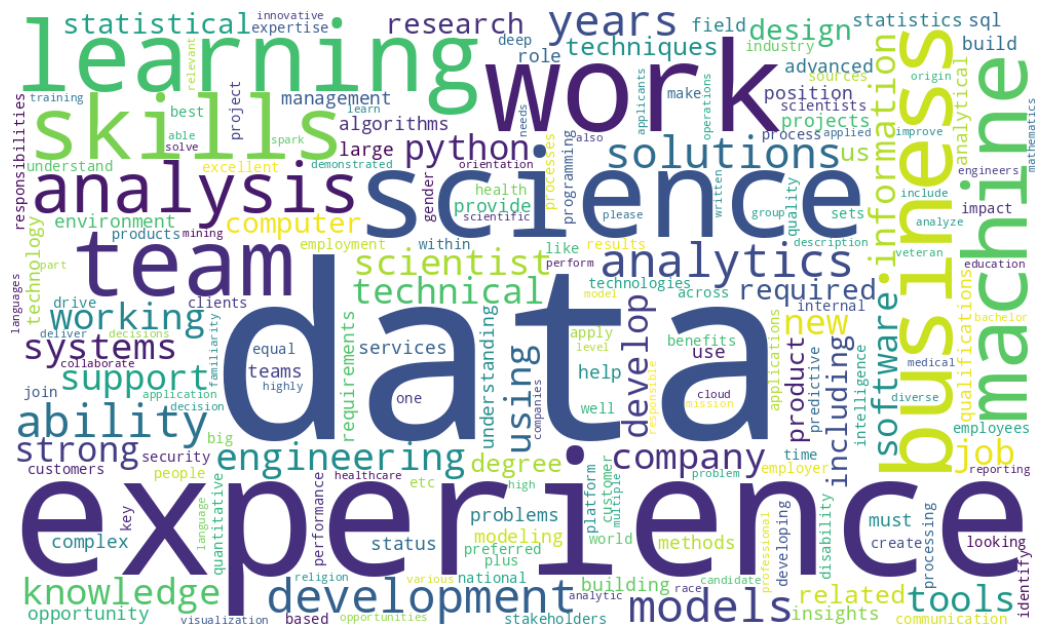

In [ ]:
#wordcloud = WordCloud(width=1000, height=600, background_color='white').generate(' '.join(jobs['Processed_Description']))
#wordcloud.to_file('wordcloud.png')  # Save the word cloud image

wordcloud_data = dict(zip(top_keywords.index, top_keywords[0]))
wordcloud = WordCloud(width=1000, height=600, background_color='white').generate_from_frequencies(wordcloud_data)
plt.figure(figsize=(20, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# From what sectors are data scientists in demand?

In [ ]:
jobs['Sector'].value_counts()

Information Technology                188
Business Services                     120
Not Specified                          71
Biotech & Pharmaceuticals              66
Aerospace & Defense                    46
Finance                                33
Insurance                              32
Manufacturing                          23
Health Care                            21
Government                             17
Oil, Gas, Energy & Utilities           10
Retail                                  7
Telecommunications                      7
Transportation & Logistics              6
Media                                   5
Real Estate                             3
Travel & Tourism                        3
Agriculture & Forestry                  3
Education                               3
Accounting & Legal                      3
Construction, Repair & Maintenance      2
Consumer Services                       2
Non-Profit                              1
Name: Sector, dtype: int64

<ipython-input-139-593292556cb6>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='Sector', data=jobs, palette='viridis', order=jobs['Sector'].value_counts().index)


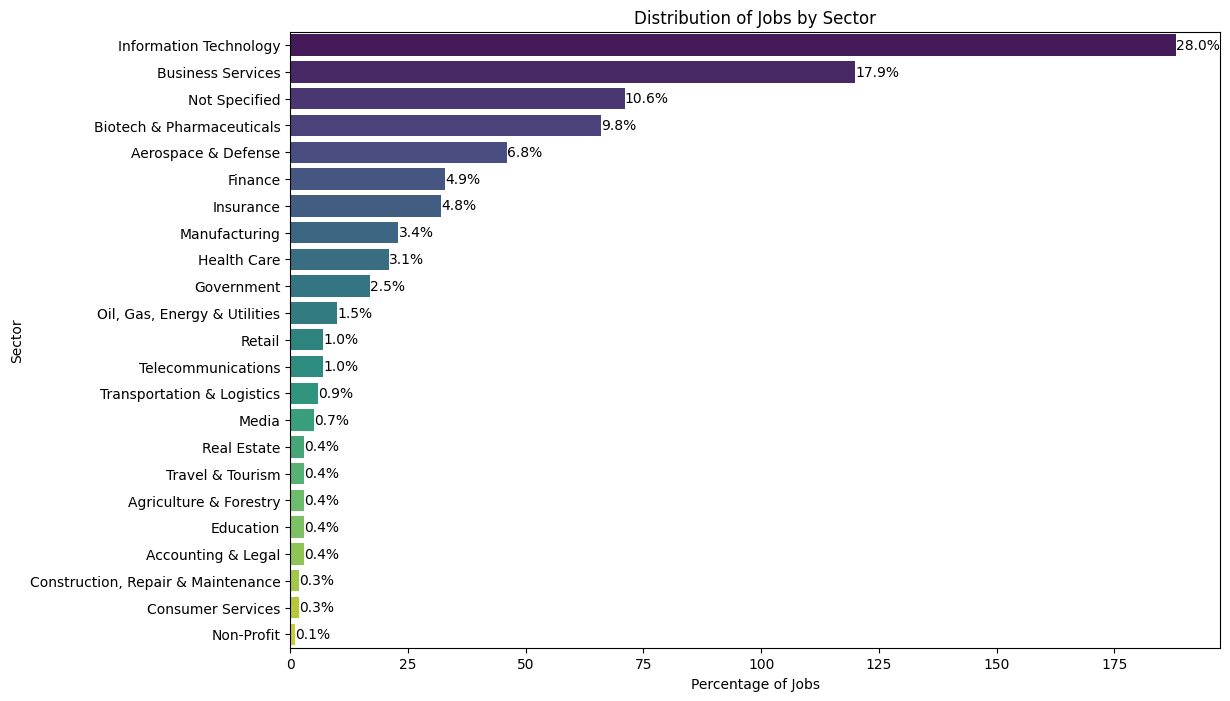

In [ ]:
plt.figure(figsize=(12, 8))
sns.countplot(y='Sector', data=jobs, palette='viridis', order=jobs['Sector'].value_counts().index)

plt.title('Distribution of Jobs by Sector')
plt.xlabel('Percentage of Jobs')
plt.ylabel('Sector')

total_jobs = len(jobs)
for p in plt.gca().patches:
    percentage = '{:.1f}%'.format((p.get_width() / total_jobs) * 100)
    x_position = p.get_x() + p.get_width() + 0.02
    y_position = p.get_y() + p.get_height() / 2
    plt.text(x_position, y_position, percentage, ha='left', va='center')

plt.show()


# Distribution of jobs by Location

In [ ]:
jobs['Location'].value_counts()

San Francisco, CA    69
New York, NY         50
Washington, DC       26
Boston, MA           24
Chicago, IL          22
                     ..
Oshkosh, WI           1
Culver City, CA       1
Lake Oswego, OR       1
New Orleans, LA       1
Irwindale, CA         1
Name: Location, Length: 207, dtype: int64

# Minimum Offer by Sector

In [ ]:
round(jobs.groupby('Sector')['Minimum Offer'].mean().sort_values(ascending=False))

Sector
Consumer Services                     158500.0
Media                                 126400.0
Retail                                119857.0
Government                            108529.0
Aerospace & Defense                   108022.0
Travel & Tourism                      106333.0
Business Services                     104567.0
Not Specified                         104014.0
Manufacturing                         100957.0
Accounting & Legal                     99667.0
Biotech & Pharmaceuticals              97955.0
Health Care                            97333.0
Education                              95333.0
Information Technology                 95037.0
Transportation & Logistics             92333.0
Finance                                91909.0
Telecommunications                     90714.0
Insurance                              88781.0
Real Estate                            87667.0
Oil, Gas, Energy & Utilities           82800.0
Agriculture & Forestry                 75667.0
Constr

# Maximum Offer by Sector

In [ ]:
round(jobs.groupby('Sector')['Maximum Offer'].mean().sort_values(ascending=False))

Sector
Consumer Services                     249000.0
Media                                 184200.0
Retail                                180429.0
Government                            160412.0
Aerospace & Defense                   157370.0
Business Services                     155592.0
Not Specified                         155324.0
Travel & Tourism                      151000.0
Accounting & Legal                    149667.0
Biotech & Pharmaceuticals             147788.0
Real Estate                           146000.0
Manufacturing                         145522.0
Transportation & Logistics            143167.0
Information Technology                142782.0
Health Care                           142190.0
Education                             140333.0
Finance                               139091.0
Telecommunications                    134000.0
Insurance                             133781.0
Agriculture & Forestry                132000.0
Oil, Gas, Energy & Utilities          119800.0
Constr

In [ ]:
duplicate_rows = jobs.duplicated()
duplicate_rows = jobs[duplicate_rows]
print(duplicate_rows)

Empty DataFrame
Columns: [index, Job Title, Salary Estimate, Job Description, Rating, Company Name, Location, Headquarters, Size, Founded, Type of ownership, Industry, Sector, Revenue, Competitors, Minimum Offer, Maximum Offer, Processed_Description]
Index: []


In [ ]:
jobs.head()

,index,Job Title,Salary Estimate,Job Description,Rating,Company Name,Location,Headquarters,Size,Founded,Type of ownership,Industry,Sector,Revenue,Competitors,Minimum Offer,Maximum Offer,Processed_Description
0,0,Sr Data Scientist,$137K-$171K (Glassdoor est.),Description\n\nThe Senior Data Scientist is re...,3.1,Healthfirst,"New York, NY","New York, NY",1001 to 5000 employees,1993,Nonprofit Organization,Insurance Carriers,Insurance,Unknown / Non-Applicable,"EmblemHealth, UnitedHealth Group, Aetna",137000,171000,description senior data scientist responsible ...
1,1,Data Scientist,$137K-$171K (Glassdoor est.),"Secure our Nation, Ignite your Future\n\nJoin ...",4.2,ManTech,"Chantilly, VA","Herndon, VA",5001 to 10000 employees,1968,Company - Public,Research & Development,Business Services,$1 to $2 billion (USD),Not Specified,137000,171000,secure nation ignite future join top informati...
2,2,Data Scientist,$137K-$171K (Glassdoor est.),Overview\n\n\nAnalysis Group is one of the lar...,3.8,Analysis Group,"Boston, MA","Boston, MA",1001 to 5000 employees,1981,Private Practice / Firm,Consulting,Business Services,$100 to $500 million (USD),Not Specified,137000,171000,overview analysis group one largest internatio...
3,3,Data Scientist,$137K-$171K (Glassdoor est.),JOB DESCRIPTION:\n\nDo you have a passion for ...,3.5,INFICON,"Newton, MA","Bad Ragaz, Switzerland",501 to 1000 employees,2000,Company - Public,Electrical & Electronic Manufacturing,Manufacturing,$100 to $500 million (USD),"MKS Instruments, Pfeiffer Vacuum, Agilent Tech...",137000,171000,job description passion data machine learning ...
4,4,Data Scientist,$137K-$171K (Glassdoor est.),Data Scientist\nAffinity Solutions / Marketing...,2.9,Affinity Solutions,"New York, NY","New York, NY",51 to 200 employees,1998,Company - Private,Advertising & Marketing,Business Services,Unknown / Non-Applicable,"Commerce Signals, Cardlytics, Yodlee",137000,171000,data scientist affinity solutions marketing cl...


In [ ]:
#jobs = jobs.to_csv('jobs.csv')